In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from discrete import *
import ot

/var/folders/dt/pgvlk7nn3sz86f4g6dg_mgrm0000gn/T/ipykernel_9279/170683086.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/dt/pgvlk7nn3sz86f4g6dg_mgrm0000gn/T/ipykernel_9279/170683086.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


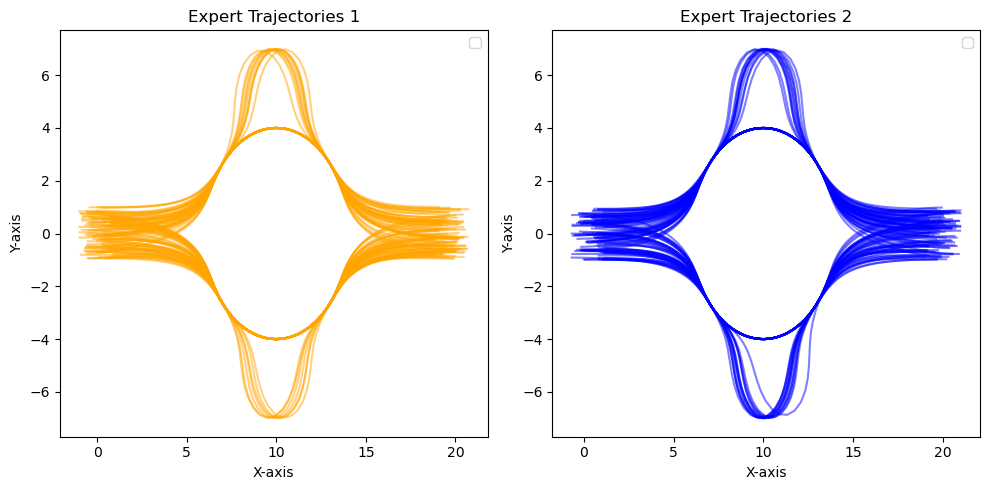

In [69]:
# Loading training trajectories
all_points1 = []    # want modes 1, 2, 4, 6
all_points2 = []    # want modes 1, 2, 3, 5
with open('data/trajs_noise1.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        x1, y1 = float(row[4]), float(row[5])
        x2, y2 = float(row[7]), float(row[8])
        all_points1.append([x1, y1])
        all_points2.append([x2, y2])

num_trajectories = 1000
points_per_trajectory = 100

expert_data1 = [
    all_points1[i * points_per_trajectory:(i + 1) * points_per_trajectory]
    for i in range(num_trajectories)
]
first_trajectory1 = expert_data1[0]
x1 = [point[0] for point in first_trajectory1]
y1 = [point[1] for point in first_trajectory1]

expert_data2 = [
    all_points2[i * points_per_trajectory:(i + 1) * points_per_trajectory]
    for i in range(num_trajectories)
]
first_trajectory2 = expert_data2[0]
x2 = [point[0] for point in first_trajectory2]
y2 = [point[1] for point in first_trajectory2]

expert_data1 = np.array(expert_data1)
expert_data2 = np.array(expert_data2)

n_traj = 100

# ranodmly select 10 trajectories from the expert data
indices = np.random.choice(num_trajectories, size=n_traj, replace=False)
expert_data1 = expert_data1[indices]
expert_data2 = expert_data2[indices]

# Plotting the trajectories
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Expert Trajectories 1")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
for trajectory in expert_data1:
    plt.plot([point[0] for point in trajectory], [point[1] for point in trajectory], alpha=0.5, color='orange')
# plt.scatter(x1, y1, color='red', label='First Trajectory')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Expert Trajectories 2")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
for trajectory in expert_data2:
    plt.plot([point[0] for point in trajectory], [point[1] for point in trajectory], alpha=0.5, color='blue')
# plt.scatter(x2, y2, color='red', label='First Trajectory')
plt.legend()   
plt.tight_layout()

In [73]:
# load the expert data
expert_data1 = np.load('data/expert_data1_100_traj.npy')
expert_data2 = np.load('data/expert_data2_100_traj.npy')

orig1 = expert_data1
orig2 = expert_data2

def create_mpc_dataset(expert_data, planning_horizon=10):
    n_traj, horizon, state_dim = expert_data.shape
    n_subtraj = horizon  # we'll create one sub-trajectory starting at each time step

    # Resulting array shape: (n_traj * n_subtraj, planning_horizon, state_dim)
    result = []

    for traj in expert_data:
        for start_idx in range(n_subtraj):
            # If not enough steps, pad with the last step
            end_idx = start_idx + planning_horizon
            if end_idx <= horizon:
                sub_traj = traj[start_idx:end_idx]
            else:
                # Need padding
                sub_traj = traj[start_idx:]
                padding = np.repeat(traj[-1][np.newaxis, :], end_idx - horizon, axis=0)
                sub_traj = np.concatenate([sub_traj, padding], axis=0)
            result.append(sub_traj)

    result = np.stack(result, axis=0)
    return result

# Use it:
mpc_data_1 = create_mpc_dataset(expert_data1, planning_horizon=10)
mpc_data_2 = create_mpc_dataset(expert_data2, planning_horizon=10)

In [87]:
# load the diffusion data and mlp data

n_traj = 10

load_path = "data/mpc_H_10"

diffusion_gnn_data1 = []
mlp_gnn_data1 = []
diffusion_gnn_data2 = []
mlp_gnn_data2 = []

for i in range(n_traj):
    mlp_gnn_data1.append(np.loadtxt(os.path.join(load_path, f"mlp_gnn_planned_traj1_{i}.csv"), delimiter=","))
    mlp_gnn_data2.append(np.loadtxt(os.path.join(load_path, f"mlp_gnn_planned_traj2_{i}.csv"), delimiter=","))
    diffusion_gnn_data2.append(np.loadtxt(os.path.join(load_path, f"diffusion_gnn_planned_traj1_{i}.csv"), delimiter=","))
    diffusion_gnn_data1.append(np.loadtxt(os.path.join(load_path, f"diffusion_gnn_planned_traj2_{i}.csv"), delimiter=","))

mlp_gnn_data1 = np.array(mlp_gnn_data1)
mlp_gnn_data2 = np.array(mlp_gnn_data2)
diffusion_gnn_data1 = np.array(diffusion_gnn_data1)
diffusion_gnn_data2 = np.array(diffusion_gnn_data2)

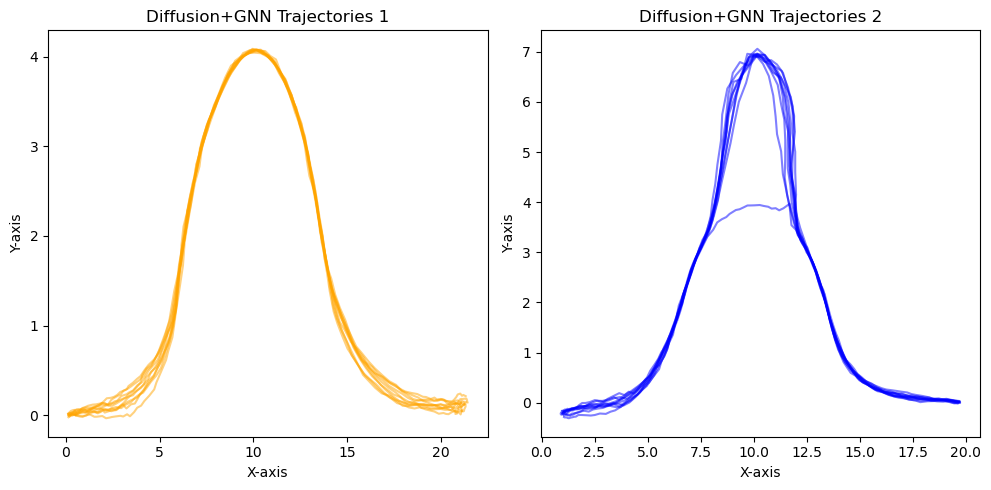

In [88]:
# Plotting diffision+gnn trajectories

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Diffusion+GNN Trajectories 1")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
# for trajectory in mlp_gnn_data1:
#     plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.5, color='orange')
for trajectory in diffusion_gnn_data1:
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.5, color='orange')
# plt.scatter(x1, y1, color='red', label='First Trajectory')

plt.subplot(1, 2, 2)
plt.title("Diffusion+GNN Trajectories 2")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
# for trajectory in mlp_gnn_data2:
#     plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.5, color='orange')
for trajectory in diffusion_gnn_data2:
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.5, color='blue')
# plt.scatter(x2, y2, color='red', label='First Trajectory')

plt.tight_layout()

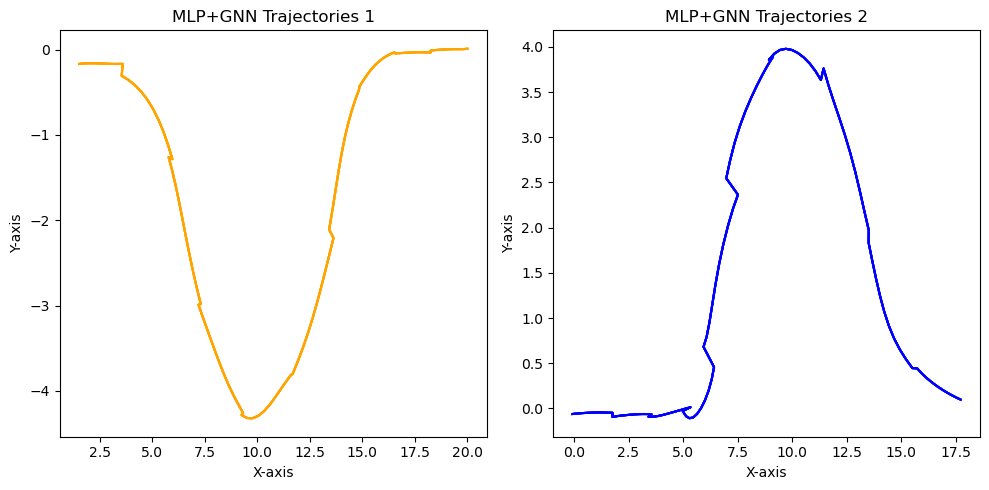

In [44]:
# Plotting mlp+gnn trajectories

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.subplot(1, 2, 1)
plt.title("MLP+GNN Trajectories 1")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

for trajectory in mlp_gnn_data1:
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.5, color='orange')

plt.subplot(1, 2, 2)
plt.title("MLP+GNN Trajectories 2")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
for trajectory in mlp_gnn_data2:
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.5, color='blue')


plt.tight_layout()

In [51]:
# compute frechet distance between the trajectories from expert and diffusion_gnn
fast_frechet = FastDiscreteFrechetMatrix(euclidean)

D_diffusion_gnn1 = np.zeros((n_traj,n_traj))
D_diffusion_gnn2 = np.zeros((n_traj,n_traj))

D_mlp_gnn1 = np.zeros((n_traj,n_traj))
D_mlp_gnn2 = np.zeros((n_traj,n_traj))

for i in range(n_traj):
    for j in range(n_traj):
        D_diffusion_gnn1[i,j] = fast_frechet.distance(expert_data1[i], diffusion_gnn_data1[j])
        D_diffusion_gnn2[i,j] = fast_frechet.distance(expert_data2[i], diffusion_gnn_data2[j])
        D_mlp_gnn1[i,j] = fast_frechet.distance(expert_data1[i], mlp_gnn_data1[j])
        D_mlp_gnn2[i,j] = fast_frechet.distance(expert_data2[i], mlp_gnn_data2[j])

w1 = np.ones(n_traj) / n_traj
w2 = np.ones(n_traj) / n_traj

# compute the optimal transport distance between the trajectories from expert and diffusion_gnn
ot_dist1 = ot.emd2(w1, w2, D_diffusion_gnn1)
ot_dist2 = ot.emd2(w1, w2, D_diffusion_gnn2)
print("Optimal Transport distance between expert and diffusion_gnn trajectories Agent-1: ", ot_dist1)
print("Optimal Transport distance between expert and diffusion_gnn trajectories Agent-2: ", ot_dist2)

# compute the optimal transport distance between the trajectories from expert and mlp_gnn
ot_dist1 = ot.emd2(w1, w2, D_mlp_gnn1)
ot_dist2 = ot.emd2(w1, w2, D_mlp_gnn2)
print("Optimal Transport distance between expert and mlp_gnn trajectories Agent-1: ", ot_dist1)
print("Optimal Transport distance between expert and mlp_gnn trajectories Agent-2: ", ot_dist2)

Optimal Transport distance between expert and diffusion_gnn trajectories Agent-1:  1.7203728567694738
Optimal Transport distance between expert and diffusion_gnn trajectories Agent-2:  2.568964613822941
Optimal Transport distance between expert and mlp_gnn trajectories Agent-1:  19.983592605184384
Optimal Transport distance between expert and mlp_gnn trajectories Agent-2:  19.94063922172311
